In [1]:
import tensorflow
import numpy
import tensorflow.keras as tfk
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import math
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
import gc

In [2]:
img_size = 17
kernel_size=(img_size,img_size)
num_channels = 102
num_classes=7
latent_space_dim = 25
beta=0.01
alpha=0.00001
LR_loss_factor=0.009
TH=0.99

In [3]:
!pip install libmr
import libmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for libmr: filename=libmr-0.1.9-cp310-cp310-linux_x86_64.whl size=533990 sha256=2feb8e9ac18095060fef470230646c95bf763ef43e1eeba2ea17cda6ba8408be
  Stored in directory: /root/.cache/pip/wheels/8a/e0/45/ec5f4f802b034150d6f5735922408cc0278bf85582b2a1a954
Successfully built libmr




**Database:**
PAVIA



In [4]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

# Download the database and save it in google drive (Only if not already existing)
import os.path

%cd /content/drive/My\ Drive/
if(os.path.exists('Amir')==False):
  !mkdir Amir
%cd Amir

if(os.path.isfile('Pavia.mat')==False):
  !wget http://www.ehu.eus/ccwintco/uploads/e/e3/Pavia.mat

if(os.path.isfile('Pavia_gt.mat')==False):
  !wget http://www.ehu.eus/ccwintco/uploads/5/53/Pavia_gt.mat

if(os.path.isfile('PaviaU.mat')==False):
  !wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat

if(os.path.isfile('PaviaU_gt.mat')==False):
  !wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

/content/drive/My Drive
/content/drive/My Drive/Amir
--2023-06-24 15:06:17--  http://www.ehu.eus/ccwintco/uploads/e/e3/Pavia.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/e3/Pavia.mat [following]
--2023-06-24 15:06:18--  https://www.ehu.eus/ccwintco/uploads/e/e3/Pavia.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129624657 (124M)
Saving to: ‘Pavia.mat’

Pavia.mat           100%[===================>] 123.62M  1.17MB/s    in 2m 18s  

2023-06-24 15:08:37 (917 KB/s) - ‘Pavia.mat’ saved [129624657/129624657]

URL transformed to HTTPS due to an HSTS policy
--2023-06-24 15:08:37--  https://www.ehu.eus/ccwintco/uploads/5/53/Pavia_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410

In [ ]:
%cd /content/drive/My\ Drive/Amir
%ls

In [7]:
import scipy.io
Pavia_gt = scipy.io.loadmat('Pavia_gt.mat')
Pavia = scipy.io.loadmat('Pavia.mat')
PaviaU_gt = scipy.io.loadmat('PaviaU_gt.mat')
PaviaU = scipy.io.loadmat('PaviaU.mat')

In [8]:
PaviaU['paviaU']=numpy.delete(PaviaU['paviaU'], 102, 2)
PaviaU['paviaU'].shape

(610, 340, 102)

In [9]:
# Normalize Database
from sklearn import preprocessing
import numpy as np

min_max_scaler = preprocessing.MinMaxScaler()

ascolumns_botswana = PaviaU['paviaU'].reshape(-1, num_channels)
t_botswana = min_max_scaler.fit_transform(ascolumns_botswana)
PaviaU['paviaU'] = t_botswana.reshape(PaviaU['paviaU'].shape)

ascolumns_botswana = Pavia['pavia'].reshape(-1, num_channels)
t_botswana = min_max_scaler.fit_transform(ascolumns_botswana)
Pavia['pavia'] = t_botswana.reshape(Pavia['pavia'].shape)



In [10]:
source_gt=PaviaU_gt['paviaU_gt']
source_data=PaviaU['paviaU']

target_gt=Pavia_gt['pavia_gt']
target_data=Pavia['pavia']

del PaviaU
del Pavia
del ascolumns_botswana
del t_botswana
gc.collect()

0

**Common Labels:**

1-Asphalt

2-Meadows

3-Shadows

4- Trees

5-Self-Blocking Bricks

6-Bare Soil

7-Bitumen

In [11]:
# remove uncommon labels
import numpy as np

source_gt=source_gt*10

result=np.where(source_gt == 10)
source_gt[result]=1

result=np.where(source_gt == 20)
source_gt[result]=2

result=np.where(source_gt == 30)
source_gt[result]=100

result=np.where(source_gt == 40)
source_gt[result]=4

result=np.where(source_gt == 50)
source_gt[result]=100

result=np.where(source_gt == 60)
source_gt[result]=6

result=np.where(source_gt == 70)
source_gt[result]=7

result=np.where(source_gt == 80)
source_gt[result]=5

result=np.where(source_gt == 90)
source_gt[result]=3


In [12]:
target_gt=target_gt*10

result=np.where(target_gt == 10)
target_gt[result]=100

result=np.where(target_gt == 20)
target_gt[result]=4

result=np.where(target_gt == 30)
target_gt[result]=1

result=np.where(target_gt == 40)
target_gt[result]=5

result=np.where(target_gt == 50)
target_gt[result]=7

result=np.where(target_gt == 60)
target_gt[result]=100

result=np.where(target_gt == 70)
target_gt[result]=3

result=np.where(target_gt == 80)
target_gt[result]=2

result=np.where(target_gt == 90)
target_gt[result]=6

In [13]:
# Zero Padding
source_data=np.pad(source_data, ((8,8),(8,8),(0,0)), 'constant', constant_values= 0)
source_gt=np.pad(source_gt, ((8,8),(8,8)), 'constant', constant_values= 0)

target_data=np.pad(target_data, ((8,8),(8,8),(0,0)), 'constant', constant_values= 0)
target_gt=np.pad(target_gt, ((8,8),(8,8)), 'constant', constant_values= 0)

gc.collect()

0

In [14]:
a=target_gt[target_gt>0].size
b=target_gt[target_gt==100].size
a-b

72933

In [15]:
a=source_gt[source_gt>0].size
b=source_gt[source_gt==100].size
a-b

39332

In [16]:
# Patch IDs

source_ID=np.where(np.logical_and(source_gt <100 , source_gt!=0))
source_ID_gt=source_gt[source_ID[0],source_ID[1]]
source_ID_gt=source_ID_gt-1

target_ID=np.where(np.logical_and(target_gt <100 , target_gt!=0))
target_ID_gt=target_gt[target_ID[0],target_ID[1]]
target_ID_gt=target_ID_gt-1

unknown_ID=np.where(target_gt ==100)  #unknown patches



In [17]:
# Shuffle Dataset

from sklearn.utils import shuffle
source_ID, source_ID_gt = shuffle(numpy.transpose(source_ID), source_ID_gt, random_state=42)
target_ID, target_ID_gt = shuffle(numpy.transpose(target_ID), target_ID_gt, random_state=42)



In [18]:
# Stratified Test/Train Splitting:

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
stratSplit.get_n_splits(source_ID, source_ID_gt)
for train_index, test_index in stratSplit.split(source_ID, source_ID_gt):
  print("Source TRAIN:", train_index, "Source TEST:", test_index)
  source_trainPatches_ID, source_testPatches_ID = source_ID[train_index], source_ID[test_index]
  source_trainPatches_ID_gt, source_testPatches_ID_gt = source_ID_gt[train_index], source_ID_gt[test_index]

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
stratSplit.get_n_splits(target_ID, target_ID_gt)
for train_index, test_index in stratSplit.split(target_ID, target_ID_gt):
  print("Target TRAIN:", train_index, "Target TEST:", test_index)
  target_trainPatches_ID, target_testPatches_ID = target_ID[train_index], target_ID[test_index]
  target_trainPatches_ID_gt, target_testPatches_ID_gt = target_ID_gt[train_index], target_ID_gt[test_index]

#target_ID=numpy.transpose(target_ID)
#source_ID=numpy.transpose(source_ID)


Source TRAIN: [ 4867 28708 16667 ... 10646 11786 15027] Source TEST: [  385 12203 30258 ... 29025 32094  3620]
Target TRAIN: [68569 52829 16025 ...  9436 27177 30809] Target TEST: [37607 39544 26691 ... 57498 28602 44981]


In [19]:
# Create a dictionary for labels
source_trainPatches_gt_dict=dict()
for i,labelvalue in enumerate(source_trainPatches_ID_gt):
  source_trainPatches_gt_dict[source_trainPatches_ID[i][0],source_trainPatches_ID[i][1]]=labelvalue


source_testPatches_gt_dict=dict()
for i,labelvalue in enumerate(source_testPatches_ID_gt):
  source_testPatches_gt_dict[source_testPatches_ID[i][0],source_testPatches_ID[i][1]]=labelvalue


target_trainPatches_gt_dict=dict()
for i,labelvalue in enumerate(target_trainPatches_ID_gt):
  target_trainPatches_gt_dict[target_trainPatches_ID[i][0],target_trainPatches_ID[i][1]]=labelvalue


target_gt_dict=dict()
for i,labelvalue in enumerate(target_ID_gt):
  target_gt_dict[target_ID[i][0],target_ID[i][1]]=labelvalue


source_gt_dict=dict()
for i,labelvalue in enumerate(source_ID_gt):
  source_gt_dict[source_ID[i][0],source_ID[i][1]]=labelvalue

**Set the random seed for Python, Numpy and Tensorflow**

In [20]:
from numpy.random import seed
import random
seed(123)
PYTHONHASHSEED=124
random.seed(125)
tensorflow.random.set_seed(126)

**The only conv layer:**








In [21]:
# The only conv layer
Ist = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels),  name="source/target_input")
conv2d_per_channel = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(img_size,img_size), strides=1, name="conv2d_per_channel")

x_st=[]
for i in range(num_channels):
  temp=Ist[:,:,:,i]
  temp2=tensorflow.keras.layers.Reshape((temp.shape[1], temp.shape[2], 1))(temp)
  temp3=conv2d_per_channel(temp2)
  x_st.append(temp3)

x_st = tensorflow.keras.layers.Concatenate(axis=3)(x_st)
x_st=tensorflow.keras.layers.Reshape([num_channels])(x_st)

x_st= tensorflow.keras.layers.LayerNormalization(axis=1)(x_st)
x_st=tensorflow.keras.activations.sigmoid(x_st)







conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")

# summarize  model
conv_model.summary()
# plot  model
#plot_model(conv_model, to_file='conv_model_plot.png', show_shapes=True, show_layer_names=True)




Model: "conv_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source/target_input (InputLaye  [(None, 17, 17, 102  0          []                               
 r)                             )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 17)      0           ['source/target_input[0][0]']    
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 17)      0           ['source/target_input[0][0]']    
 icingOpLambda)                                                                          

**Encoder:**

Model: "encoder_final_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 102)]        0           []                               
                                                                                                  
 encoder_dense1 (Dense)         (None, 70)           7210        ['encoder_input[0][0]']          
                                                                                                  
 layer_normalization_1 (LayerNo  (None, 70)          140         ['encoder_dense1[0][0]']         
 rmalization)                                                                                     
                                                                                                  
 encoder_dense2 (Dense)         (None, 30)           2130        ['layer_normali

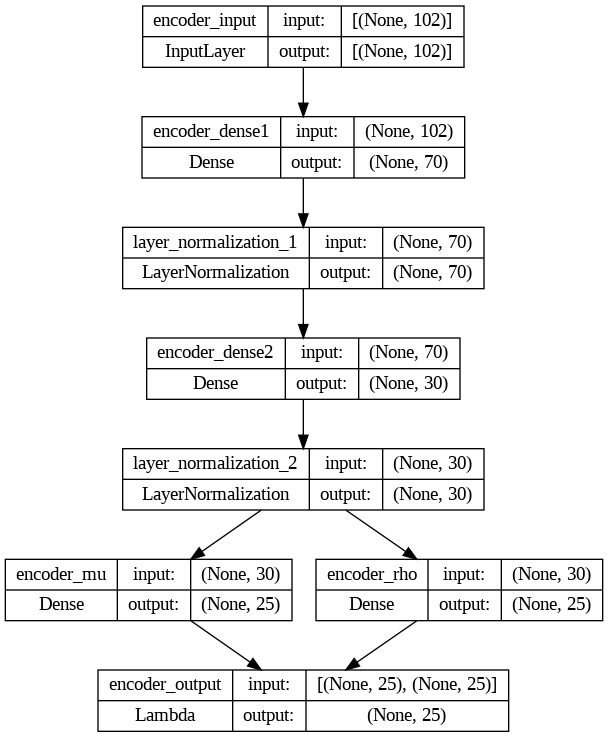

In [22]:
# Encoder
e_x = tensorflow.keras.layers.Input(shape=(num_channels), name="encoder_input")


encoder_dense1 = tensorflow.keras.layers.Dense(units=70,activation='tanh', name="encoder_dense1")(e_x)
encoder_dense1=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense1)
encoder_dense2 = tensorflow.keras.layers.Dense(units=30,activation='tanh', name="encoder_dense2")(encoder_dense1)
encoder_dense2=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense2)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_dense2)
encoder_rho = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_rho")(encoder_dense2)


def sampling_z_only(mu_rho):
        mu,rho=mu_rho
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tensorflow.random.normal(shape=(latent_space_dim,))
        return z_sample



encoder_output = tensorflow.keras.layers.Lambda(sampling_z_only, name="encoder_output")([encoder_mu, encoder_rho])


encoder_mu_rho_model = tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
encoder_final_model = tensorflow.keras.models.Model(e_x, encoder_output, name="encoder_final_model")



# summarize  model
encoder_final_model.summary()
# plot  model
plot_model(encoder_final_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

**Decoder:**

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 25)]              0         
                                                                 
 decoder_dense1 (Dense)      (None, 30)                780       
                                                                 
 layer_normalization_3 (Laye  (None, 30)               60        
 rNormalization)                                                 
                                                                 
 decoder_dense2 (Dense)      (None, 70)                2170      
                                                                 
 layer_normalization_4 (Laye  (None, 70)               140       
 rNormalization)                                                 
                                                                 
 decoder_output (Dense)      (None, 102)             

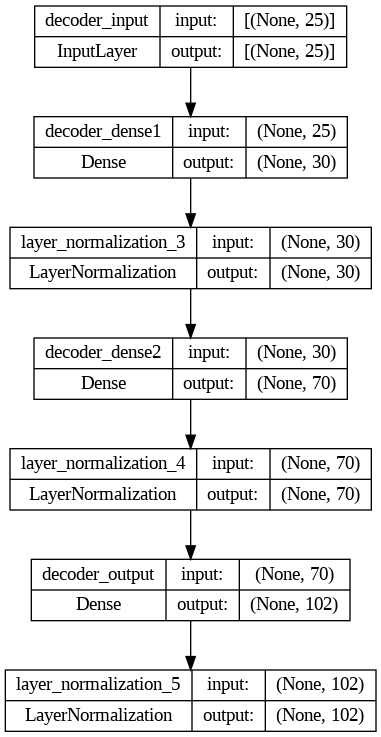

In [23]:
#decoder_input = r_s
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense1 = tensorflow.keras.layers.Dense(units=30, activation='tanh', name="decoder_dense1")(decoder_input)
decoder_dense1=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense1)
decoder_dense2 = tensorflow.keras.layers.Dense(units=70, activation='tanh', name="decoder_dense2")(decoder_dense1)
decoder_dense2=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense2)
decoder_output = tensorflow.keras.layers.Dense(units=num_channels, name="decoder_output")(decoder_dense2)
decoder_output= tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_output)
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

# summarize  model
decoder.summary()
# plot  model
plot_model(decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)


**Classifiers:**

Model: "c1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1_input (InputLayer)       [(None, 25)]              0         
                                                                 
 c1_output (Dense)           (None, 7)                 182       
                                                                 
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


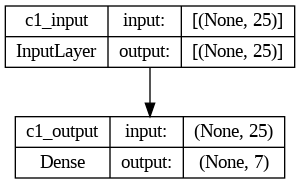

In [24]:
# Classifier1
c1_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="c1_input")
#c1_intermediate1 = tensorflow.keras.layers.Dense(units=50, activation='tanh', kernel_initializer='he_uniform', name="c1_intermediate1")(c1_input)
#c1_intermediate2 = tensorflow.keras.layers.Dense(units=25, activation='tanh', kernel_initializer='he_uniform', name="c1_intermediate2")(c1_intermediate1)
c1_output = tensorflow.keras.layers.Dense(units=num_classes, activation='softmax', name="c1_output")(c1_input)

c1 = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")

# summarize  model
c1.summary()
# plot  model
plot_model(c1, to_file='c1_plot.png', show_shapes=True, show_layer_names=True)

Model: "c2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c2_input (InputLayer)       [(None, 25)]              0         
                                                                 
 c2_output (Dense)           (None, 7)                 182       
                                                                 
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


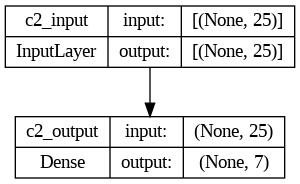

In [25]:
# Classifier2
c2_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="c2_input")
#c2_intermediate1 = tensorflow.keras.layers.Dense(units=50, activation='tanh', kernel_initializer='he_uniform', name="c2_intermediate1")(c2_input)
#c2_intermediate2 = tensorflow.keras.layers.Dense(units=25, activation='tanh', kernel_initializer='he_uniform', name="c2_intermediate2")(c2_intermediate1)
c2_output = tensorflow.keras.layers.Dense(units=num_classes, activation='softmax', name="c2_output")(c2_input)

c2 = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

# summarize  model
c2.summary()
# plot  model
plot_model(c2, to_file='c2_plot.png', show_shapes=True, show_layer_names=True)

**Step 1:**

In [26]:
class step_1_model_class(tfk.Model):

    def __init__(self, dim_z, kl_weight=1, LR_FACTOR=1, name="step_1_model", **kwargs):
        super(step_1_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.c1_s = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_s = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")
        self.kl_weight = kl_weight


    def custom_sigmoid_cross_entropy_loss_with_logits(self,x_true, x_recons_logits): # Reconstruction loss In case of Bernoulli distribution assumption
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=-1)

        return tf.math.reduce_mean(neg_log_likelihood)

    def vae_reconstruction_loss(self,y_true, y_predict):    # Reconstruction loss In case of Gaussian distribution assumption
        reconstruction_loss_factor = 1/2
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-tf.sigmoid(y_predict)), axis=-1)
        reconstruction_loss=tf.math.log(reconstruction_loss*2*math.pi)
        return tensorflow.keras.backend.mean(reconstruction_loss_factor * reconstruction_loss)

    def vae_kl_loss(self,encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=-1)
        return tensorflow.keras.backend.mean(kl_loss)

    def encode(self, x_input):
        mu1,rho1 = self.encoder(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1





    def call(self, x_input):
        conv_out=self.conv_model(x_input)
        z_sample1, mu1, rho1 = self.encode(conv_out)
        x_logits = self.decoder(z_sample1)
        z1_s=self.c1_s(z_sample1)
        z2_s=self.c2_s(z_sample1)
        # Add Losses:
        self.add_loss(LR_loss_factor*self.kl_weight * self.vae_kl_loss(mu1,rho1))
        self.add_loss(LR_loss_factor*self.custom_sigmoid_cross_entropy_loss_with_logits(conv_out,x_logits))
        #self.add_loss(LR_loss_factor*self.vae_reconstruction_loss(conv_out,x_logits2))
        return z1_s,z2_s




In [27]:
    conv_model.trainable = True
    encoder_final_model.trainable = True
    decoder.trainable = True
    c1.trainable = True
    c2.trainable = True

In [28]:
Model_step1 = step_1_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_step1.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(),
            loss={'output_1':'categorical_crossentropy','output_2':'categorical_crossentropy'},metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [29]:
# Generator Class

import numpy as np
import keras


#class DataGenerator(keras.utils.all_utils.Sequence):
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataname, list_IDs, labels, batch_size=32, dim=(17,17), n_channels=102,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataname=dataname

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]

            # Store class
            y[i] = self.labels[ID[0],ID[1]]

        return X, keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)

**Note:**` You can Skip running this snippet and uncomment and run the next snippet instead, in order to load already trained weights for step1:`

In [30]:
## Start Training (Step 1):

#import numpy as np
#import multiprocessing
# Parameters
#params = {'dim': (17,17),
#          'batch_size': 32,
#          'n_classes': 7,
#          'n_channels': 102,
#          'shuffle': True}
## Generators
#training_generator = DataGenerator(source_data, source_trainPatches_ID, source_trainPatches_gt_dict, **params)
#validation_generator = DataGenerator(source_data, source_testPatches_ID, source_testPatches_gt_dict, **params)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
#mc = ModelCheckpoint('pavia_best_model1_chkp',save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

#Model_step1.fit_generator(generator=training_generator,
#                    validation_data=validation_generator,
#                    use_multiprocessing=True,
#                    callbacks=[es,mc],
#                    epochs=5000,
#                    workers=multiprocessing.cpu_count())


##Load the best saved checkpoint
#Model_step1.load_weights('pavia_best_model1_chkp')



In [31]:
# Uncomment these lines to load already trained weights for step 1:

import os

if(os.path.isfile('AlreadyLearnedWeights_pavia_step1.index')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_pavia_step1.index

if(os.path.isfile('AlreadyLearnedWeights_pavia_step1.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_pavia_step1.data-00000-of-00001

Model_step1.load_weights('AlreadyLearnedWeights_pavia_step1')
Model_step1.save_weights('pavia_best_model1_chkp')


In [32]:
params = {'dim': (17,17),
          'batch_size': 32,
          'n_classes': 7,
          'n_channels': 102,
          'shuffle': True}


In [33]:
# Evaluate on Target
target_generator = DataGenerator(target_data,target_ID, target_gt_dict, **params)
Model_step1.evaluate_generator(generator=target_generator)

<ipython-input-33-0bf1ba59b0ce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Model_step1.evaluate_generator(generator=target_generator)


[12.743138313293457,
 6.328968524932861,
 6.333232402801514,
 0.4706971347332001,
 0.4710673689842224]

In [34]:
# Evaluate on Source
source_generator = DataGenerator(source_data,source_ID, source_gt_dict, **params)
Model_step1.evaluate_generator(generator=source_generator)

<ipython-input-34-e8cd0395a7c1>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Model_step1.evaluate_generator(generator=source_generator)


[0.053136926144361496,
 0.0013931550784036517,
 0.0013929081615060568,
 0.9996694326400757,
 0.9996694326400757]

In [ ]:
# Try to find unknowns based on confidence percentage (just for evaluation of this method's performance)

params = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': 7,
          'n_channels': 102,
          'shuffle': False}
unknown_generator = DataGenerator(target_data,unknown_ID, target_gt_dict, **params)
outp1=Model_step1.predict_generator(generator=target_generator)

#outp1,_=Model_step1.predict(unknown_patches)
outp1_maxes=numpy.amax(outp1,axis=-1)
result=np.where(outp1_maxes<0.5)
len(result[0])
print("The Confidence level for (",len(result[0]),"/",75219,"=",len(result[0])*100/75219,"% ) of unknowns is below 50%. Other unknowns are classified as known classes with high confidence!")

In [36]:
unknown_mode=False  #If you want to run the network in closed set mode, you can set unknown_mode=false and skip (Finding Unknowns) part.
                    #In that case, you may continue running the code from (step3a model) part.

**Finding Unknowns:**

In [37]:
unknown_mode=True

In [38]:
class recons2_model_class(tfk.Model):

    def __init__(self, dim_z, kl_weight=1, LR_FACTOR=1, name="recons2", **kwargs):
        super(recons2_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

        self.conv_model.trainable=False
        self.encoder.trainable=True
        self.decoder.trainable=True



    def vae_reconstruction_loss(self,y_true, y_predict):    # Reconstruction loss In case of Gaussian distribution assumption
        reconstruction_loss_factor = 1/2
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-tf.sigmoid(y_predict)), axis=-1)
        reconstruction_loss=tf.math.log(reconstruction_loss*2*math.pi)
        return (reconstruction_loss_factor * reconstruction_loss)


    def encode(self, x_input):
        mu2,rho2 = self.encoder(x_input)
        sd2=tensorflow.keras.backend.exp(rho2/2);
        z_sample2 = mu2 + sd2 * tf.random.normal(shape=(self.dim_z,))
        return z_sample2





    def call(self, x_input):
        conv_out=self.conv_model(x_input)
        z_sample2 = self.encode(conv_out)
        x_logits2 = self.decoder(z_sample2)
        # Add Losses:
        loss_ae=1*self.vae_reconstruction_loss(conv_out,x_logits2)
        self.add_loss(tensorflow.keras.backend.mean(loss_ae))
        return loss_ae




In [39]:
Model_recons2 = recons2_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_recons2.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam())

**Note:**` You can Skip running this snippet and uncomment and run the next snippet instead, in order to load already trained weights for step2:`

In [40]:
## Train
#import numpy as np
#import multiprocessing
## Parameters
#params = {'dim': (17,17),
#          'batch_size': 32,
#          'n_classes': 7,
#          'n_channels': 102,
#          'shuffle': True}

#training_generator = DataGenerator(source_data, source_trainPatches_ID, source_trainPatches_gt_dict, **params)



#Model_recons2.fit_generator(generator=training_generator,
#                    use_multiprocessing=True,
#                    epochs=300,
#                    workers=multiprocessing.cpu_count())


In [41]:
# Uncomment these lines to load already trained weights for step 2:

import os

if(os.path.isfile('AlreadyLearnedWeights_pavia_step2.index')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_pavia_step2.index

if(os.path.isfile('AlreadyLearnedWeights_pavia_step2.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_pavia_step2.data-00000-of-00001

Model_step1.load_weights('AlreadyLearnedWeights_pavia_step2')

In [42]:
def extract_patches(dataname, list_IDs):
  #self.dataname=dataname
  #self.list_IDs=list_IDs
  batch_size = list_IDs.shape[0]
  batch = np.empty((batch_size, img_size,img_size, num_channels))
  for i, ID in enumerate(list_IDs):
    # Store sample
    batch[i,] = dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]
  return batch

In [43]:
# Augmentation function
import numpy as np
def perform_augmentation(data, gt):
  flipV=np.flip(data,1)
  flipH=np.flip(data,2)
  flipHV=np.flip(flipH,1)
  return np.concatenate((flipV,flipH,flipHV,data),axis=0) , np.concatenate((gt,gt,gt,gt),axis=0)


In [44]:
# Loss Calculations (With Live Augmentation)

n_batch=128 #128 # number of samples in each batch

loss_hist=np.ones(4*source_trainPatches_ID_gt.shape[0])

int_division=int(source_trainPatches_ID_gt.shape[0]/n_batch)
remainingSamples=source_trainPatches_ID_gt.shape[0]-int_division*n_batch
if(remainingSamples)>0:
  n_parts=int_division+1
else:
  n_parts=int_division

for j in range(n_parts):
    if(j<int_division):
      source_batch=extract_patches(source_data, source_trainPatches_ID[j*n_batch:j*n_batch+n_batch])
      source_batch_gt=source_trainPatches_ID_gt[j*n_batch:j*n_batch+n_batch]
      source_batch_new,source_batch_new_gt = perform_augmentation(source_batch,source_batch_gt)  # augmentation
      loss_hist[j*n_batch*4:j*n_batch*4+n_batch*4]=Model_recons2.predict(source_batch_new)
    else:
      source_batch=extract_patches(source_data,source_trainPatches_ID[int_division*n_batch:int_division*n_batch+remainingSamples])
      source_batch_gt=source_trainPatches_ID_gt[int_division*n_batch:int_division*n_batch+remainingSamples]
      source_batch_new,source_batch_new_gt = perform_augmentation(source_batch,source_batch_gt)  # augmentation
      loss_hist[int_division*n_batch*4:int_division*n_batch*4+remainingSamples*4]=Model_recons2.predict(source_batch_new)


9/9 [==============================] - 3s 12ms/step


In [45]:
# histogram high tail Model ( EVA )

loss_hist=loss_hist.astype('double')

mr = libmr.MR()
mr.fit_high(loss_hist,int(0.05*len(source_trainPatches_ID_gt)))



**Remove Unknowns from target_trainPatches:**

In [46]:
# Concat 0.9 of unknowns with target_trainPatches
#75219*0.9=67697
target_and_unknown_train_ID=numpy.concatenate((numpy.transpose(unknown_ID)[0:67697],target_trainPatches_ID),axis=0)
target_and_unknown_train_ID_gt=numpy.concatenate((7*np.ones(67697),target_trainPatches_ID_gt),axis=0)
len(target_and_unknown_train_ID_gt)




133336

In [47]:
# Shufle again
target_and_unknown_train_ID, target_and_unknown_train_ID_gt = shuffle(target_and_unknown_train_ID, target_and_unknown_train_ID_gt, random_state=42)
target_and_unknown_train_ID_gt.max()

7.0

In [48]:
# Target_all
target_all_ID=numpy.concatenate((target_ID,numpy.transpose(unknown_ID)),axis=0)
target_all_ID_gt=numpy.concatenate((target_ID_gt,7*np.ones(75219)),axis=0)
len(target_all_ID_gt)


148152

In [49]:
# Create a dictionary for labels
target_and_unknown_train_gt_dict=dict()
for i,labelvalue in enumerate(target_and_unknown_train_ID_gt):
  target_and_unknown_train_gt_dict[target_and_unknown_train_ID[i][0],target_and_unknown_train_ID[i][1]]=labelvalue

target_all_dict=dict()
for i,labelvalue in enumerate(target_all_ID_gt):
  target_all_dict[target_all_ID[i][0],target_all_ID[i][1]]=labelvalue

In [50]:
# Predict based on the high tail model

params = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': 8,
          'n_channels': 102,
          'shuffle': False}
tu_train_generator = DataGenerator(target_data,target_and_unknown_train_ID, target_and_unknown_train_gt_dict, **params)
targetpredict=Model_recons2.predict_generator(generator=tu_train_generator)

#targetpredict=Model_recons2.predict(target_trainPatches)
targetpredict=targetpredict.astype('double')


wscore = mr.w_score_vector(targetpredict)
mask = wscore>TH # threshold TH


result=np.where(mask == True)
len(result[0])

<ipython-input-50-e3ad5095e109>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  targetpredict=Model_recons2.predict_generator(generator=tu_train_generator)


68293

In [51]:
# Remove unknowns from target_tarinPatches
target_trainPatches_ID=target_and_unknown_train_ID[np.where(mask == False)[0],:]
target_trainPatches_ID_gt=target_and_unknown_train_ID_gt[np.where(mask == False)[0]]


**Find Unknowns on all target data:**

In [52]:
# Predict based on the high tail model

params = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': 8,
          'n_channels': 102,
          'shuffle': False}
target_all_generator = DataGenerator(target_data,target_all_ID, target_all_dict, **params)
targetpredict=Model_recons2.predict_generator(generator=target_all_generator)

#targetpredict=Model_recons2.predict(target_all)
targetpredict=targetpredict.astype('double')


wscore = mr.w_score_vector(targetpredict)
mask = wscore>TH # threshold TH


predicted_unknowns_all=np.where(mask == True)
len(predicted_unknowns_all[0])

<ipython-input-52-e84fd37d4784>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  targetpredict=Model_recons2.predict_generator(generator=target_all_generator)


70240

In [53]:
# Number of unknowns that are recognized
result2=np.where(target_all_ID_gt[predicted_unknowns_all]==7)
len(result2[0])
print(len(result2[0]),"of 75219 unknowns were correctly recognized as unknown.")
print(len(predicted_unknowns_all[0])-len(result2[0]),"of 72933 samples with known classes were falsely recognized as unknows.")

64267 of 75219 unknowns were correctly recognized as unknown.
5973 of 72933 samples with known classes were falsely recognized as unknows.


**Step 3a Model:**

In [54]:
#Load the weights from step 1
Model_step1.load_weights('pavia_best_model1_chkp')


In [55]:
class step_3a_model_class(tfk.Model):

    def __init__(self, dim_z,euclidean_Weight, name="ganb", **kwargs):
        super(step_3a_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.euclidean_Weight=euclidean_Weight
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.c1_st = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_st = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

        self.conv_model.trainable=False
        self.encoder.trainable=False
        self.c1_st.trainable=True
        self.c2_st.trainable=True


    def encode(self, x_input):
        mu,rho = self.encoder(x_input)
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, rho





    def call(self, x_input):
        input_s,input_t=x_input
        conv_out_s=self.conv_model(input_s)
        conv_out_t=self.conv_model(input_t)
        z_sample_t, mu, rho = self.encode(conv_out_t)
        z_sample_s, mu, rho = self.encode(conv_out_s)
        z1_s=self.c1_st(z_sample_s)
        z2_s=self.c2_st(z_sample_s)
        z1_t=self.c1_st(z_sample_t)
        z2_t=self.c2_st(z_sample_t)
        euclidean_loss=K.sqrt(K.sum(K.square(z1_t - z2_t), axis=-1))
        #euclidean_loss=tf.math.log(euclidean_loss)  ## !
        # Add Loss:
        self.add_loss(-self.euclidean_Weight*tf.math.reduce_mean(euclidean_loss))
        return z1_s,z2_s


In [56]:
    Model_step3a = step_3a_model_class(dim_z=latent_space_dim,euclidean_Weight=alpha)
    Model_step3a.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.00005),
            loss={'output_1':'categorical_crossentropy','output_2':'categorical_crossentropy'}, metrics=[tf.keras.metrics.CategoricalAccuracy()])

**Step 3b Model:**

In [57]:

class step_3b_model_class(tfk.Model):

    def __init__(self, dim_z, name="ganc", **kwargs):
        super(step_3b_model_class, self).__init__(name=name, **kwargs)
        self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder =   tensorflow.keras.models.Model(e_x, (encoder_mu,encoder_rho), name="encoder_mu_rho_model")
        self.conv_model = tensorflow.keras.models.Model(Ist, x_st, name="conv_model")
        self.c1_t = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_t = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

        self.conv_model.trainable=True
        self.encoder.trainable=True
        self.c1_t.trainable=False
        self.c2_t.trainable=False


    def encode(self, x_input):
        mu,rho = self.encoder(x_input)
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, rho





    def call(self, x_input):
        conv_out=self.conv_model(x_input)
        z_sample, mu, rho = self.encode(conv_out)
        z1_t=self.c1_t(z_sample)
        z2_t=self.c2_t(z_sample)
        euclidean_loss=K.sqrt(K.sum(K.square(z1_t - z2_t), axis=-1))
        #euclidean_loss=tf.math.log(euclidean_loss)  ##!
        # Add Loss:
        self.add_loss(tf.math.reduce_mean(euclidean_loss))
        return None


In [58]:
    Model_step3b = step_3b_model_class(dim_z=latent_space_dim)
    Model_step3b.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.00005))


**Train Steps 3a & 3b :**

In [59]:
def extract_patches(dataname, list_IDs):
  #self.dataname=dataname
  #self.list_IDs=list_IDs
  batch_size = list_IDs.shape[0]
  batch = np.empty((batch_size, img_size,img_size, num_channels))
  for i, ID in enumerate(list_IDs):
    # Store sample
    batch[i,] = dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]
  return batch

In [60]:
params = {'dim': (17,17),
          'batch_size': 32,
          'n_classes': 7,
          'n_channels': 102,
          'shuffle': True}
target_generator = DataGenerator(target_data,target_ID, target_gt_dict, **params)

**Note:**` You can Skip running this snippet and uncomment and run the next snippet instead, in order to load already trained weights for step3:`

In [61]:
## Start Training (Steps 3a & 3b) :

#n_epochs=500
#n_batch=128 # number of samples in each batch
#shuffle_before_each_epoch=True
#early_stop_enabled=True
#max_patience=40


#minimumSampleNumber=min(source_trainPatches_ID_gt.shape[0],target_trainPatches_ID_gt.shape[0])
#int_division=int(minimumSampleNumber/n_batch)
#remainingSamples=minimumSampleNumber-int_division*n_batch
#if(remainingSamples)>0:
#  n_parts=int_division+1
#else:
#  n_parts=int_division

#patience_count=0
#min_bc=float('inf')
#for i in range(n_epochs):
#  gc.collect()
#  print('\n')

#  if(shuffle_before_each_epoch==True):
#    source_trainPatches_ID, source_trainPatches_ID_gt = shuffle(source_trainPatches_ID, source_trainPatches_ID_gt, random_state=42)
#    target_trainPatches_ID, target_trainPatches_ID_gt = shuffle(target_trainPatches_ID, target_trainPatches_ID_gt, random_state=42)
#  for j in range(n_parts):
#    if(j<int_division):
#      source_batch=extract_patches(source_data, source_trainPatches_ID[j*n_batch:j*n_batch+n_batch])
#      target_batch=extract_patches(target_data, target_trainPatches_ID[j*n_batch:j*n_batch+n_batch])
#      source_batch_gt=source_trainPatches_ID_gt[j*n_batch:j*n_batch+n_batch]

#    else:
#      source_batch=extract_patches(source_data,source_trainPatches_ID[int_division*n_batch:int_division*n_batch+remainingSamples])
#      target_batch=extract_patches(target_data,target_trainPatches_ID[int_division*n_batch:int_division*n_batch+remainingSamples])
#      source_batch_gt=source_trainPatches_ID_gt[int_division*n_batch:int_division*n_batch+remainingSamples]


#    source_batch_gt=keras.utils.np_utils.to_categorical(source_batch_gt, num_classes)

#    if (j==0):
#      should_reset_metrics=True
#    else:
#      should_reset_metrics=False

#    lossb,lossb1,lossb2,acc1,acc2=Model_step3a.train_on_batch([source_batch,target_batch], [source_batch_gt,source_batch_gt],reset_metrics=should_reset_metrics)


#    lossc=Model_step3b.train_on_batch(target_batch,None,reset_metrics=should_reset_metrics)

#    print('\rEpoch '+ str(i+1)+'/'+str(n_epochs)+' Step '+ str(j+1)+ '/'+ str(n_parts)+ ': acc1=', str(acc1)+ ' acc2='+ str(acc2)+' lossb='+str(lossb)+' lossb1='+
#          str(lossb1)+' lossb2='+str(lossb2)+' lossc='+str(lossc), end=''),
#  #Early stopping:
#  if(early_stop_enabled==True):
#    #total_lossbc=lossc
#    total_lossbc=lossc-lossb # minimizing generator loss and maximizing discriminator loss
#    if(total_lossbc<min_bc):
#      min_bc=total_lossbc
#      patience_count=0
#      Model_step1.save_weights('pavia_best_model3_chkp')
#      print("\nCheckPoint Saved")
#    else:
#      patience_count=patience_count+1;
#      if (patience_count>=max_patience):
#        print("\nEarly Stopping..")
#        break

##Load the best saved checkpoint
#Model_step1.load_weights('pavia_best_model3_chkp')

In [62]:
# Uncomment these lines to load already trained weights for step 3:

import os

if(os.path.isfile('AlreadyLearnedWeights_pavia_step3.index')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_pavia_step3.index

if(os.path.isfile('AlreadyLearnedWeights_pavia_step3.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/OpenSet_CrossScene_HSI/raw/main/AlreadyLearnedWeights_pavia_step3.data-00000-of-00001

Model_step1.load_weights('AlreadyLearnedWeights_pavia_step3')


In [64]:
from sklearn.metrics import classification_report
import numpy as np


if unknown_mode==True:
  params = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': 8,
          'n_channels': 102,
          'shuffle': False}
  target_generator = DataGenerator(target_data,target_all_ID, target_all_dict, **params)
else:
  params = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': 7,
          'n_channels': 102,
          'shuffle': False}
  target_generator = DataGenerator(target_data,target_ID, target_gt_dict, **params)
y_pred=Model_step1.predict_generator(generator=target_generator)
y_pred=np.argmax(y_pred[0],axis=1)
if unknown_mode==True:
  y_pred[predicted_unknowns_all]=num_classes #7  # predicted unknowns
  print(classification_report(target_all_ID_gt,y_pred,digits=3 ))
else:
  print(classification_report(target_ID_gt,y_pred,digits=3 ))

<ipython-input-64-e6896d0a8674>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred=Model_step1.predict_generator(generator=target_generator)


              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      3090
         1.0      0.818     0.994     0.897     42826
         2.0      0.008     0.004     0.005      7287
         3.0      0.875     0.960     0.916      7598
         4.0      0.004     0.004     0.004      2685
         5.0      0.000     0.001     0.000      2863
         6.0      0.000     0.000     0.000      6584
         7.0      0.915     0.854     0.884     75219

    accuracy                          0.771    148152
   macro avg      0.328     0.352     0.338    148152
weighted avg      0.746     0.771     0.755    148152



/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


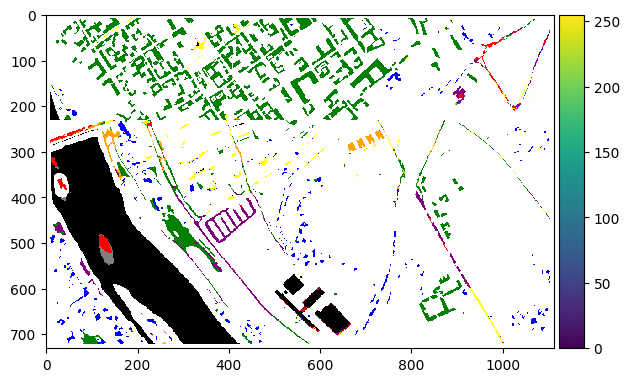

In [65]:
# Final Classification Map

from skimage import io
from skimage import color
from skimage import segmentation
import matplotlib.pyplot as plt
import numpy as np

tp_indexes=target_ID
uk_indexes=unknown_ID

backgr=np.zeros([1112,731])
seg=np.zeros([1112,731])
for ii in range(len(tp_indexes)):
  seg[tp_indexes[ii][0],tp_indexes[ii][1]]=y_pred[ii]+1

if unknown_mode==True:
 for ii in range(len(uk_indexes[0])):
   seg[uk_indexes[0][ii],uk_indexes[1][ii]]=y_pred[ii+len(tp_indexes)]+1




# Generate colouring from classification labels
io.imshow(color.label2rgb(seg.transpose(),backgr.transpose(),bg_color=(255,255,255),colors=('red','green','yellow','blue','orange','purple','grey','black')
,bg_label=0,alpha=1))
plt.show()

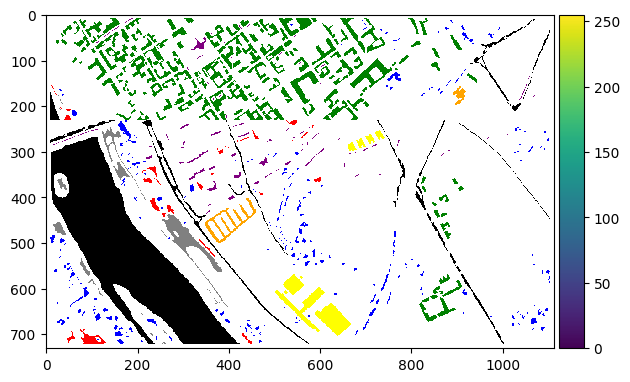

In [66]:
# Ground truth


io.imshow(color.label2rgb(target_gt.transpose(),np.zeros([731,1112]),bg_color=(255,255,255),colors=('red','green','yellow','blue','orange','purple','grey','black')
,bg_label=0,alpha=1))
plt.show()


In [67]:
# Save Final Weights
Model_step1.save_weights('pavia_final_weights')
